# Imports

In [6]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tkinter.filedialog import askdirectory
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import trapezoid
from scipy.signal import butter, filtfilt, find_peaks
from numpy.fft import fft

# Function definitions

In [7]:
# Functions from Quantacell

def filter_peaks_by_shape(peaks, signal, min_slope=5, window=10, verbose=False):
    """
    Filters peaks based on their shape by analyzing slopes and width.

    :param peaks: np.ndarray, indices of detected peaks.
    :param signal: np.ndarray, 1D signal.
    :param min_slope: float, minimum slope to consider a peak as sharp.
    :param window: int, window size.
    :return: np.ndarray, indices of filtered peaks.
    """
    filtered_peaks, filtered_peaks_indexes = [], []
    for k, peak in enumerate(peaks):
        # if peak <= (window // 2) or peak == len(signal) - (window // 2):
        if peak == 0 or peak == len(signal) - 1:
            if verbose:
                print(f'Peak {peak} ignored (signal edge).')
            continue
        
        start_left = max(0, peak - window)
        end_left = peak
        start_right = peak + 1
        end_right = min(len(signal), peak + 1 + window)
        
        # Compute slope on the left and on the right
        left_slope = (signal[peak] - np.mean(signal[start_left:end_left])) / (end_left - start_left)
        right_slope = (signal[peak] - np.mean(signal[start_right:end_right])) / (end_right - start_right)
        
        if left_slope < min_slope or right_slope < min_slope:
            if verbose:
                print(f'Peak {peak} ignored (low slope): ls = {left_slope} rs = {right_slope}')
            continue
        
        if verbose:
            print(f'Peak {peak} ignored (low slope): ls = {left_slope} rs = {right_slope}')
        filtered_peaks_indexes.append(k)
        filtered_peaks.append(peak)
    
    return np.array(filtered_peaks), np.array(filtered_peaks_indexes)


def filter_by_duration_and_calculate(peaks, threshold, signal, sample_rate=30,
                                     min_duration=0.1, min_flow=-1, verbose=False):
    """
    Filters peaks based on their duration above a threshold, computes the area
    of each expansion above the threshold.
    
    :param peaks: np.ndarray, indices of detected peaks.
    :param threshold: float, threshold.
    :param signal: np.ndarray, 1D signal.
    :param sample_rate: int, sampling rate of the signal.
    :param min_duration: float, minimum duration in seconds.
    :param min_flow: float, minimum flow of expansion.
    :return: tuple, filtered peaks, their durations, their areas and flows.
    """
    valid_peaks, durations, areas, flows = [], [], [], []
    sample_rate = max(1e-6, sample_rate) # preventing zero division
    for peak in peaks:
        peak_time = np.round(peak / sample_rate, 3)
        start = peak
        while start > 0 and signal[start] > threshold:
            start -= 1
        end = peak
        while end < len(signal) and signal[end] > threshold:
            end += 1
        end = min(end, len(signal) - 1)
        duration = (end - start) / sample_rate
        segment_times = np.arange(start, end + 1)
        area = np.abs(trapezoid(np.maximum(signal[start:end+1] - threshold, 0), segment_times)).astype(int)
        area_flow = area * duration
        if duration >= min_duration and area_flow >= min_flow:
            valid_peaks.append(peak)
            durations.append(duration)
            areas.append(area)
            flows.append(area_flow)
        elif verbose:
            print(f'Peak {peak} at {peak_time}s ignored (not last long enough): duration = {duration} flow = {area_flow}')
    return np.array(valid_peaks), durations, areas, flows


def filter_close_peaks(peaks, signal, min_distance, verbose=False):
    """
    Removes peaks that are too close to each other.

    :param peaks: np.ndarray, indices of detected peaks.
    :param signal: np.ndarray, 1D signal.
    :param durations: list, durations of each peak.
    :param min_distance: int, minimum allowed distance between peaks.
    :return: tuple, filtered peaks and durations.
    """
    if len(peaks) == 0:
        return peaks, []
    filtered_peaks = [peaks[0]]
    filtered_peaks_indexes = [0]
    # filtered_durations = [durations[0]]
    for i in range(1, len(peaks)):
        if peaks[i] - filtered_peaks[-1] >= min_distance:
            filtered_peaks.append(peaks[i])
            filtered_peaks_indexes.append(i)
            # filtered_durations.append(durations[i])
        else:
            if signal[peaks[i]] > signal[filtered_peaks[-1]]:
                if verbose:
                    print(f'Peak {peaks[i]} removed (too close from {filtered_peaks[-1]}).')
                filtered_peaks[-1] = peaks[i]
                filtered_peaks_indexes[-1] = i
                # filtered_durations[-1] = durations[i]
    return np.array(filtered_peaks), filtered_peaks_indexes


def filter_edge_peaks(peaks, signal_length, min_distance_from_edges, verbose=False):
    """
    Filtre les pics proches des extrémités du signal.
    
    :param peaks: np.ndarray, indices des pics détectés.
    :param signal_length: int, longueur totale du signal.
    :param min_distance_from_edges: int, distance minimale des extrémités.
    :return: np.ndarray, indices des pics après filtrage.
    """
    filetered_peaks = []
    for peak in peaks:
        if peak >= min_distance_from_edges and peak <= (signal_length - min_distance_from_edges):
            filetered_peaks.append(peak)
        elif verbose:
            print(f'Peak {peak} removed (too close from edges).')
    return np.array(filetered_peaks)
    # return np.array([peak for peak in peaks if peak >= min_distance_from_edges and peak <= (signal_length - min_distance_from_edges)])



def analyze_signal_peaks(signal, prct_1=10, prct_2=90, sample_rate=30,
                         min_duration=0.1, min_distance=10,
                         min_flow=1000, min_slope=10, window_slope_size=10,
                         verbose=False):
    """
    Analyzes a 1D signal to detect and filter high and low peaks based on various thresholds and parameters.
    It identifies peaks, filters them by duration, distance, and shape, and computes additional properties such as
    the area and flow for each peak.

    :param signal: np.ndarray
        A 1D numpy array representing the signal to analyze.

    :param prct_1: int, optional, default=10
        The percentile value for detecting low peaks. Values below this percentile are considered low peaks.

    :param prct_2: int, optional, default=90
        The percentile value for detecting high peaks. Values above this percentile are considered high peaks.

    :param sample_rate: int, optional, default=30
        The sample rate of the signal, which is used to convert durations and distances from indices to seconds.

    :param min_duration: float, optional, default=0.1
        The minimum duration (in seconds) that a peak must last in order to be considered significant. 

    :param min_distance: int, optional, default=10
        The minimum distance between consecutive peaks (in indices). Peaks that are too close together are filtered out.

    :param min_flow: float, optional, default=1000
        The minimum flow, representing the strength of a peak's contraction or expansion, calculated as the area between
        the peak and its threshold.

    :param min_slope: float, optional, default=10
        The minimum slope required for the peak's shape to be considered valid.

    :param window_slope_size: int, optional, default=10
        The window size used to calculate the slope to the left and right of each peak.

    :param verbose: bool, optional, default=False
        If set to True, additional information will be printed during the processing steps.

    """
    assert prct_1 < prct_2
    low_percentile = np.percentile(signal, prct_1)
    high_percentile = np.percentile(signal, prct_2)
    MH_highpeaks=0.5*np.max(signal)
    MH_lowpeaks=np.min(signal)+0.2*np.max(signal)
    high_peaks, _ = find_peaks(signal, height=MH_highpeaks)
    low_peaks, _ = find_peaks(-signal, height=-MH_lowpeaks)

    high_peaks = filter_edge_peaks(high_peaks, len(signal), min_distance_from_edges=5)
    low_peaks = filter_edge_peaks(low_peaks, len(signal), min_distance_from_edges=5)

    high_peaks, high_durations, high_areas, high_flows = filter_by_duration_and_calculate(high_peaks, MH_highpeaks,
                                                                  signal, sample_rate,
                                                                  min_duration, min_flow, verbose)
    low_peaks, low_durations, low_areas, low_flows = filter_by_duration_and_calculate(low_peaks, -MH_lowpeaks,
                                                                -signal, sample_rate,
                                                                min_duration, min_flow, verbose)
    # Filter close peak
    min_distance_in_idx = int(np.round(min_distance * sample_rate))
    high_peaks, high_indexes = filter_close_peaks(high_peaks, signal,
                                                    min_distance_in_idx, verbose)
    low_peaks, low_indexes = filter_close_peaks(low_peaks, -signal,
                                                  min_distance_in_idx, verbose)
    high_durations = [high_durations[idx] for idx in high_indexes if idx in high_indexes]
    low_durations = [low_durations[idx] for idx in low_indexes if idx in low_indexes]
    high_areas = [high_areas[idx] for idx in high_indexes if idx in high_indexes]
    low_areas = [low_areas[idx] for idx in low_indexes if idx in low_indexes]
    high_flows = [high_flows[idx] for idx in high_indexes if idx in high_indexes]
    low_flows = [low_flows[idx] for idx in low_indexes if idx in low_indexes]
    
    # Filter by shape
    high_peaks, high_indexes = filter_peaks_by_shape(high_peaks, signal,
                                                     min_slope, window_slope_size,
                                                     verbose=verbose)
    low_peaks, low_indexes = filter_peaks_by_shape(low_peaks, -signal,
                                                   min_slope, window_slope_size,
                                                   verbose=verbose)
    high_durations = [high_durations[idx] for idx in high_indexes if idx in high_indexes]
    low_durations = [low_durations[idx] for idx in low_indexes if idx in low_indexes]
    high_areas = [high_areas[idx] for idx in high_indexes if idx in high_indexes]
    low_areas = [low_areas[idx] for idx in low_indexes if idx in low_indexes]
    high_flows = [high_flows[idx] for idx in high_indexes if idx in high_indexes]
    low_flows = [low_flows[idx] for idx in low_indexes if idx in low_indexes]
    
    # Résultats
    results = {
        "low_percentile_value": prct_1,
        "high_percentile_value": prct_2,
        "low_percentile": low_percentile,
        "high_percentile": high_percentile,
        "high_amplitude": MH_highpeaks,
        "low_amplitude": MH_lowpeaks,
        "high_peak_indices": high_peaks.tolist(),
        "low_peak_indices": low_peaks.tolist(),
        "high_peak_durations": high_durations,
        "low_peak_durations": low_durations,
        'high_areas': high_areas,
        'low_areas': low_areas,
        'high_flows': high_flows,
        'low_flows': low_flows,
        "total_number_of_peaks": len(low_peaks) + len(high_peaks)
    }
    return results


def plot_signal_with_filtered_peaks(signal, sample_rate, results, title=None):
    """
    Plots the signal with detected and filtered high and low peaks.

    :param signal: np.ndarray, 1D signal.
    :param sample_rate: int, signal sampling rate.
    :param results: dict, results of peak analysis.
    :param title: str, optional, plot title.
    """
    time = np.arange(len(signal)) / sample_rate
    
    prct_1_value = results['low_percentile_value']
    prct_2_value = results['high_percentile_value']
    high_peaks = results["high_peak_indices"]
    low_peaks = results["low_peak_indices"]
    low_percentile = results["low_percentile"]
    high_percentile = results["high_percentile"]
    low_amplitude = results["low_amplitude"]
    high_amplitude = results["high_amplitude"]

    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, label="Signal", color="blue", linewidth=1.5)

    plt.axhline(high_percentile, color="green", linestyle="--", label=f"{prct_1_value} percentile")
    plt.axhline(low_percentile, color="red", linestyle="--", label=f"{prct_2_value} percentile")

    if len(high_peaks) > 0:
        plt.scatter(time[high_peaks], signal[high_peaks], color="orange", label="High peak(s)", zorder=5)
    
    if len(low_peaks) > 0:
        plt.scatter(time[low_peaks], signal[low_peaks], color="purple", label="Low peak(s)", zorder=5)

    if title is None:
        title = "Signal avec Pics Hauts et Bas Filtrés"
    plt.title(title, fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()


def signaltonoise(a, axis=0, ddof=0):
    '''Signal to noise ratio of signal a.
    Parameters:
    a is an array
    '''
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

# Mathilde's function


def sort_peaks_troughs(signal,peaks, all_troughs, Window):
    '''
    Sorts peaks and troughs and checks if they match.
    Parameters:
    peaks (list or array-like): Indices of the peaks in the signal.
    all_troughs (list or array-like): Indices of all troughs in the signal.
    Returns:
    tuple: Peaks, pretroughs, troughs, passs, message.
    Peaks, pretroughs and troughs are lists of indices.
    Passs is a boolean indicating if the signal should be skipped.
    Message is a string with a reason for skipping the signal.
    '''

    filtered_troughs = []
    last_troughs = []  # list to store last min after each peak
    first_troughs = all_troughs[all_troughs < peaks[0]]   # First, check for troughs before the first peak 
    dSignal=np.diff(signal)
    epsilon=max(dSignal)*0.005

    if len(first_troughs) > 0:
        last_troughs.append(first_troughs[-1])  # add the closest trough to first peak to last_troughs

    for i in range(len(peaks)):
        # find all troughs after this peak and before next peak
        if i == len(peaks) - 1: next_troughs = all_troughs[all_troughs > peaks[i]] # for the peak before the last one
        else: next_troughs = all_troughs[(all_troughs > peaks[i]) & (all_troughs < peaks[i+1])] #take all the troughs between peak i and i+1
        if len(next_troughs) > 0:     # if there are multiple troughs after a peak or before first peak, keep only the closest ones
            find_trough=0
            T_cursor=0
            while find_trough==0  and len(next_troughs)-1>T_cursor:
                if np.mean(dSignal[next_troughs[T_cursor]:next_troughs[T_cursor+1]])<-epsilon:T_cursor+=1 #Trough should be at the end of the peak, where derivative is very small
                else:find_trough=1         
                
            filtered_troughs.append(next_troughs[T_cursor])
            last_troughs.append(next_troughs[-1]) # keep the last one for last_troughs list

    troughs = np.array(filtered_troughs)
    pretroughs = np.array(last_troughs)

    

    if pretroughs[0] > peaks[0]: # Ensure the first beat starts with a pretrough
        peaks = peaks[1:]
    if len(peaks) < 2:
        message = 'One or less peaks found. Onto the next signal.'
        return None, None, None, True, message
    
    if len(troughs)==0 or len(pretroughs)==0:
        message = 'One or less peaks found. Troughs or pretroughs=0. Onto the next signal.'
        return None, None, None, True, message

    if peaks[-1] > troughs[-1]: # Ensure the last peak ends with a trough
        peaks = peaks[:-1]
    if len(peaks) < 2:
        message = 'One or less peaks found. Onto the next signal.'
        return None, None, None, True, message

    if pretroughs[-1] > peaks[-1]: # Ensure the last pretrough is before the last peak
        pretroughs = pretroughs[:-1]
    if troughs[0] < peaks[0]: # Ensure the first trough is after the first peak
        troughs = troughs[1:]

    if len(peaks) != len(troughs) or len(peaks) != len(pretroughs):     # if each peak doesn't have a pretrough before and a trough after, pass
        message = 'Peaks, troughs and pretroughs do not match. Onto the next signal.'
        return None, None, None, True, message
    
    return peaks, pretroughs, troughs, False, None




def get_ContractionPoints(i, CR_percents, peaks, strain_vector,time_vector, pretroughs, troughs):
    '''
    Function to compute contraction/relaxation time values for each percentage.
    Parameters:
    i (int): Index of the signal.
    CR_percents (list): List of contraction and relaxation percentages to compute.
    peaks (list): List of peak indices.
    signal (DataFrame): DataFrame containing the signal data.
    pretroughs (list): List of pretrough indices.
    troughs (list): List of trough indices.
    Returns:
    tuple: relax, relax x, relax y, contrac x, contrac y.
    relax, relax x, relax y are dictionaries containing the Strain values and corresponding times for each relaxation percentage.
    contrac, contrac x, contrac y are dictionaries containing the Strain values and corresponding times for each contraction percentage.
    '''
    # Create lists to store all APD values
    relax_x = {f'relax{p}_x': [] for p in CR_percents}
    relax_y = {f'relax{p}_y': [] for p in CR_percents}
    contrac = {f'contrac{p}': [] for p in CR_percents}
    relax = {f'relax{p}': [] for p in CR_percents}
    contrac_x = {f'contrac{p}_x': [] for p in CR_percents}  
    contrac_y = {f'contrac{p}_y': [] for p in CR_percents}

    for i in range(len(peaks)):
        peak_value = strain_vector[peaks[i]]
        trough_value = strain_vector[troughs[i]]
        pretrough_value = strain_vector[pretroughs[i]]
                
        # Calculate target values for each contrac/relax percentage
        targets_contrac = {f'target_{p}_on': (p/100)*(peak_value-pretrough_value)+pretrough_value for p in CR_percents}
        targets_relax = {f'target_{p}': peak_value - (p/100)*(peak_value-trough_value) for p in CR_percents}
        
                
        for p in CR_percents:
            crossings_off = []
            crossings_on = []
            target_contrac = targets_contrac[f'target_{p}_on']
            target_relax = targets_relax[f'target_{p}']
            
            #Relaxation      
            for j in range(peaks[i], troughs[i]): # find all crossings between peak and trough
                if (strain_vector[j-1] >= target_relax >= strain_vector[j]) or (strain_vector[j-1] <= target_relax <= strain_vector[j]):
                    crossings_off.append(j)

            #Contraction        
            for j in range(pretroughs[i], peaks[i]): # find all crossings between pretrough and peak
                if (strain_vector[j-1] <= target_contrac <= strain_vector[j]) or (strain_vector[j-1] >= target_contrac >= strain_vector[j]):
                    crossings_on.append(j)
                    
            # Store the results if crossings were found
            if crossings_off:
                last_idx = crossings_off[-1]
                off_duration = time_vector[last_idx] - time_vector[peaks[i]]
                relax[f'relax{p}'].append(off_duration)
                relax_y[f'relax{p}_y'].append(strain_vector[last_idx])
                relax_x[f'relax{p}_x'].append(time_vector[last_idx])
                    
            if crossings_on:
                first_idx = crossings_on[0]
                contrac[f'contrac{p}'].append(time_vector[first_idx]-time_vector[pretroughs[i]])
                contrac_x[f'contrac{p}_x'].append(time_vector[first_idx])
                contrac_y[f'contrac{p}_y'].append(strain_vector[first_idx])

    return relax, relax_x, relax_y, contrac, contrac_x, contrac_y

# Parameters

In [8]:
# Parameters for analysis
Initial_Youngs_Modulus=11
Days_Culture=14
Youngs_Modulus=-0.3366*Days_Culture+Initial_Youngs_Modulus

# PARAMETERS USED TO FILTER PEAKS OUT
PRCT_1 = 15
PRCT_2 = 50
MIN_EXPANSION_FLOW = 0 # in pixels**2 * seconds
WINDOW_SLOPE_SIZE = 50
MIN_SLOPE = 0

# Main

## Load data

In [9]:
# Load files
# Selecting folder to analyse (folder containing all conditions)
folder = input('Select the folder containing all the folders containing csv files to analyse')

conditions = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f)) and not f.startswith('Results')] # get only folders in folder except Results folder
if len(conditions)==0 :
    print('WARNING: No conditions found in folder. Exiting...')
    exit()

## Data analysis

Analyzing condition: DMSO for Mex & Met
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_B4b_DMSO_ch00_SV_prediction_features
0.9939759036144579
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_B4d_DMSO_ch00_SV_prediction_features
0.6325301204819278
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_B4e_DMSO_ch00_SV_prediction_features
0.3614457831325301
Peaks, troughs and pretroughs do not match. Onto the next signal.
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_B4g_DMSO_ch00_SV_prediction_features
0.3614457831325301
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_B4h_DMSO_ch00_SV_prediction_features
0.9939759036144579
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_C4d_DMSO_ch00_SV_prediction_features
0.27108433734939763
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_C4e_DMSO_ch00_SV_prediction_feat

C:\Users\inesb\AppData\Local\Temp\ipykernel_18680\1744938508.py:371: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(13, 3.5))


Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_F4e_DMSO_ch00_SV_prediction_features
0.9036144578313253
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_F4h_DMSO_ch00_SV_prediction_features
0.9939759036144579
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_F4i_DMSO_ch00_SV_prediction_features
1.0843373493975905
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_G4a_DMSO_ch00_SV_prediction_features
1.174698795180723
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_G4d_DMSO_ch00_SV_prediction_features
0.18072289156626506
Peaks, troughs and pretroughs do not match. Onto the next signal.
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_G4e_DMSO_ch00_SV_prediction_features
0.09036144578313253
One or less peaks found. Onto the next signal.
Processing file:  260824_D14_10x obj_videos_DMSO___AK07_260824_D14_10x obj_G4f_DMSO_ch00_SV_predicti

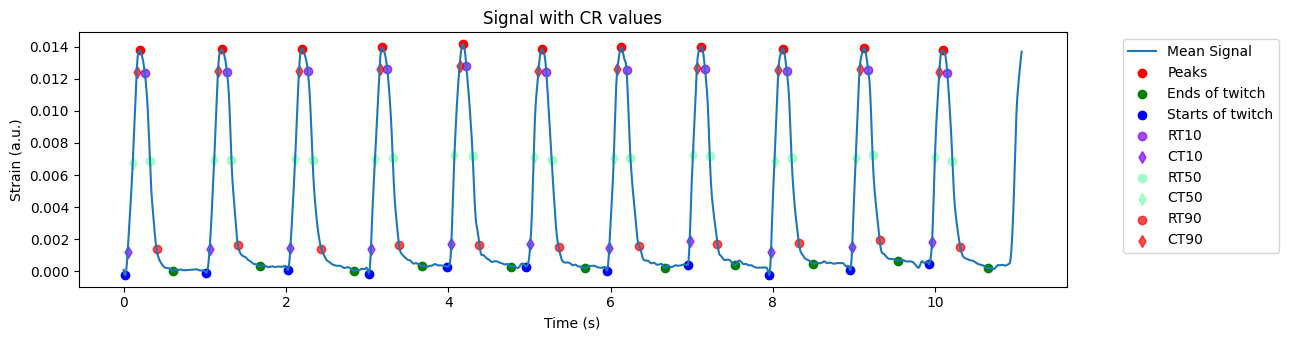

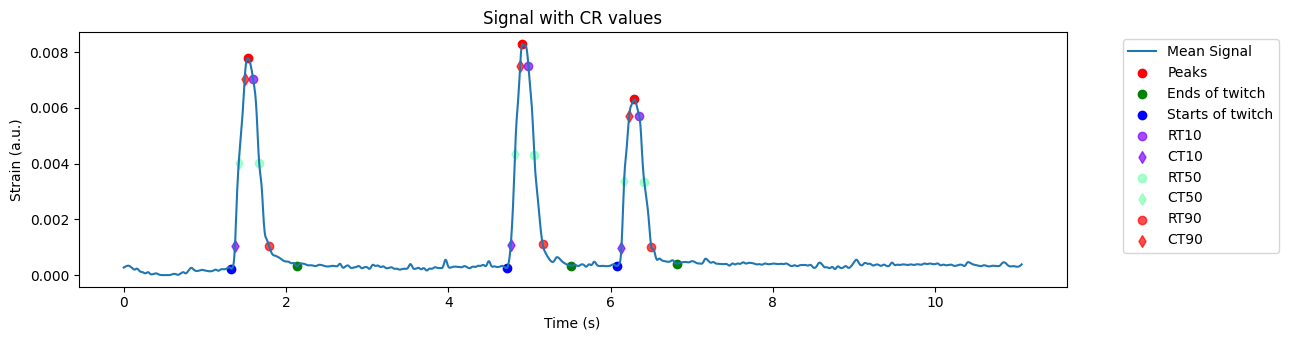

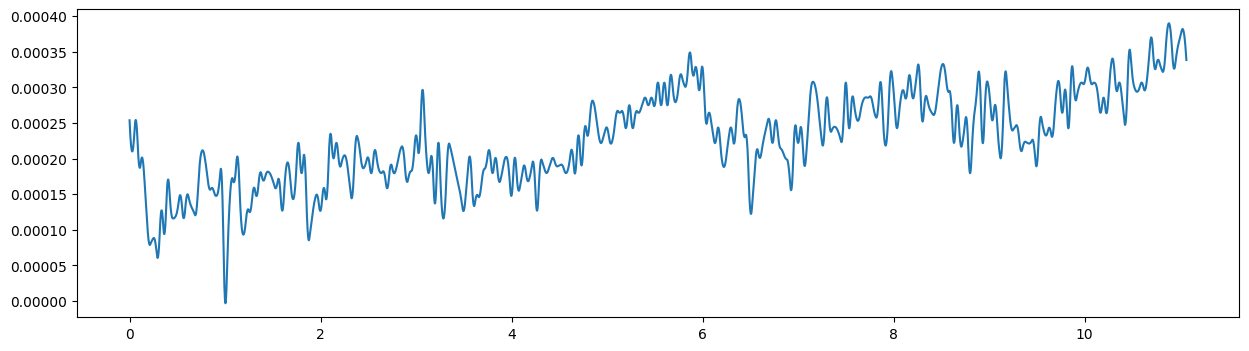

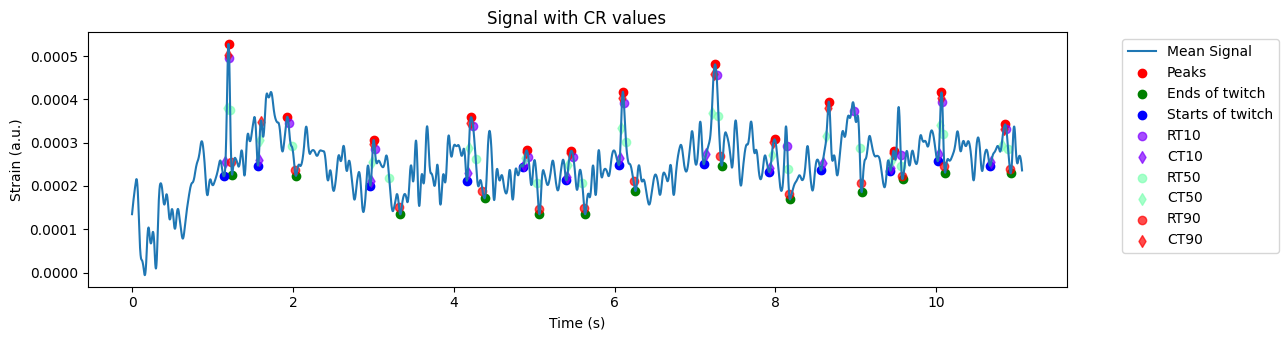

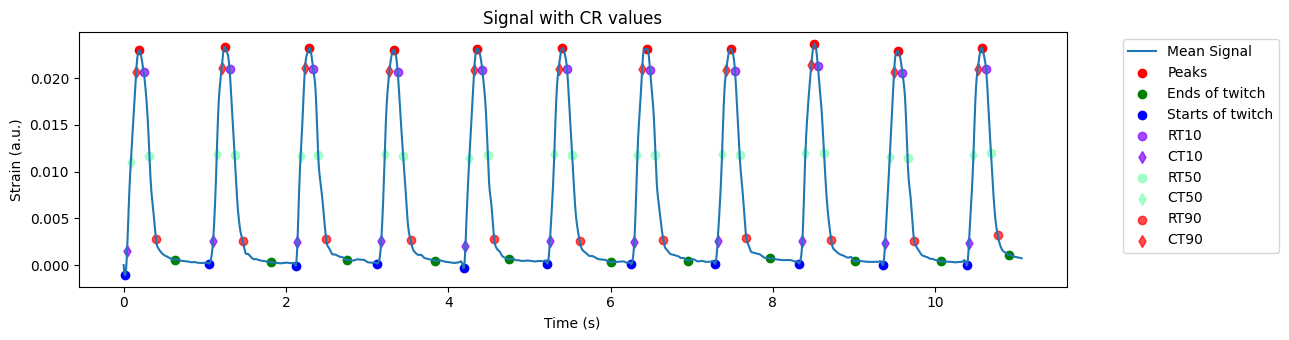

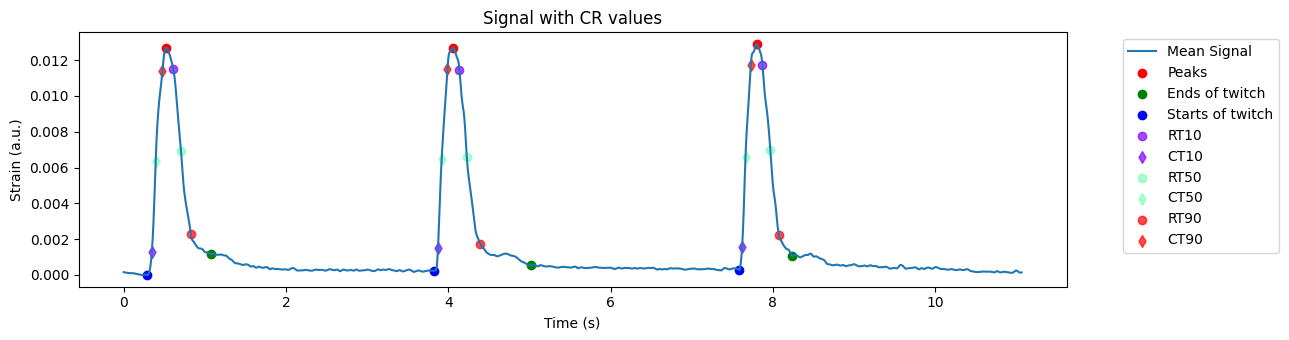

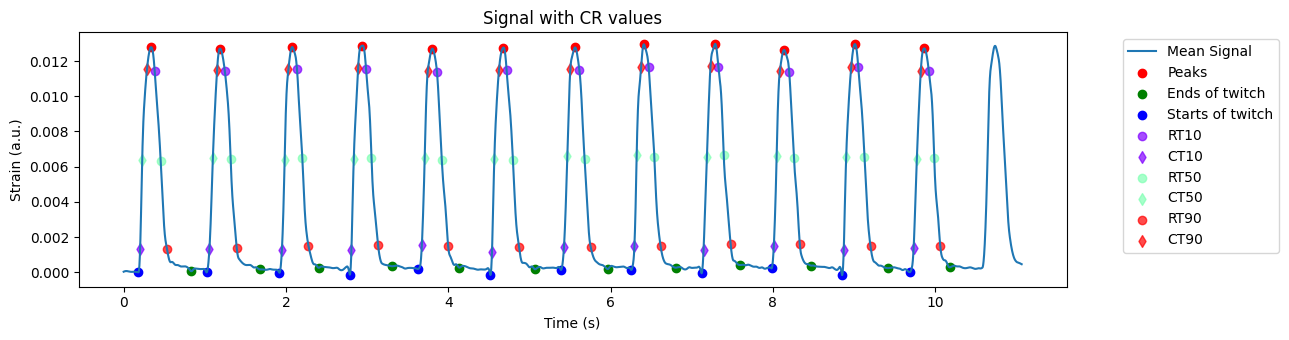

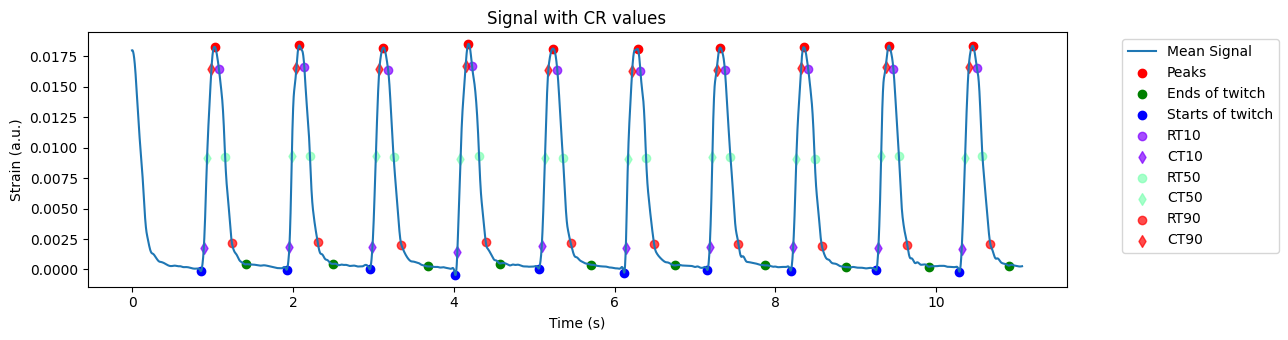

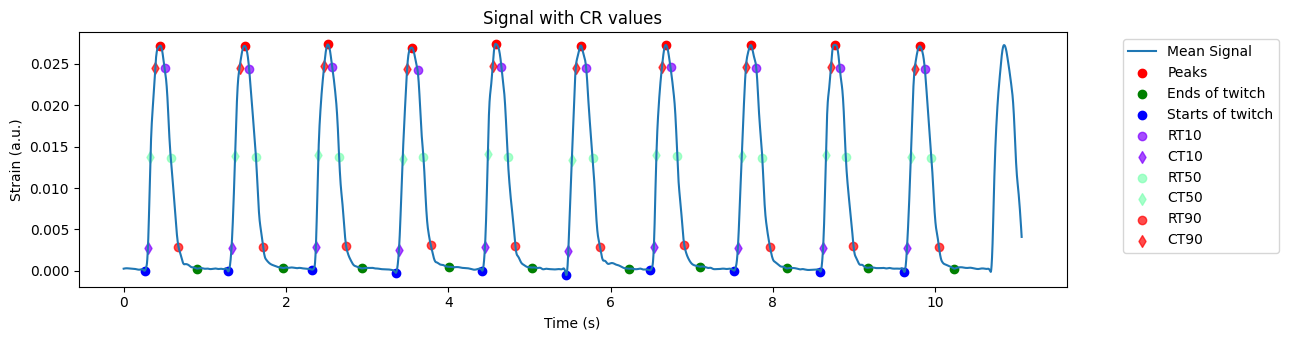

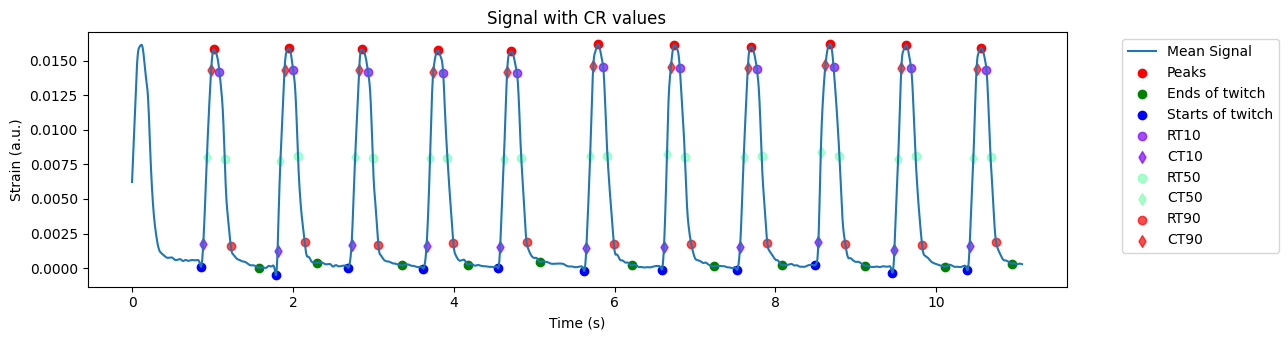

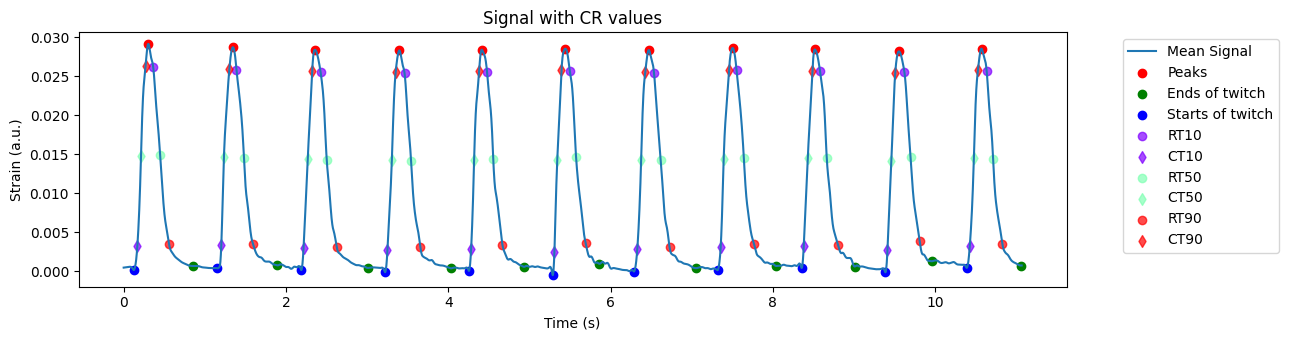

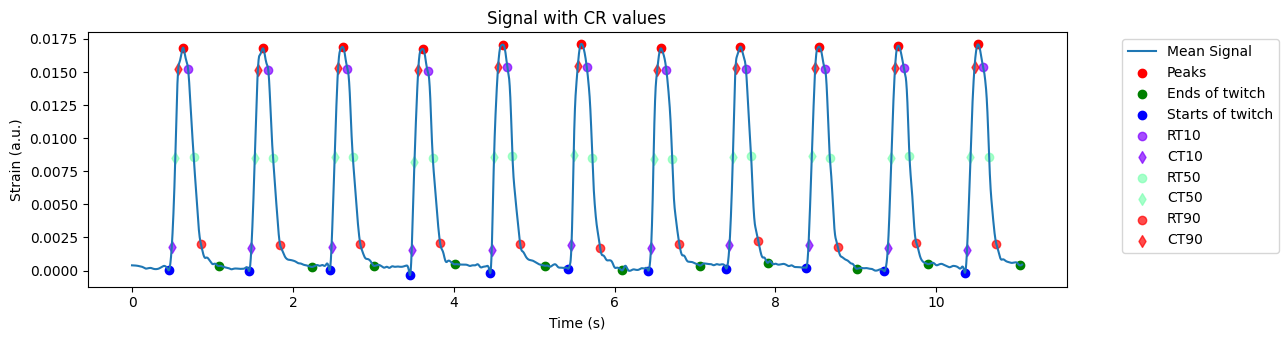

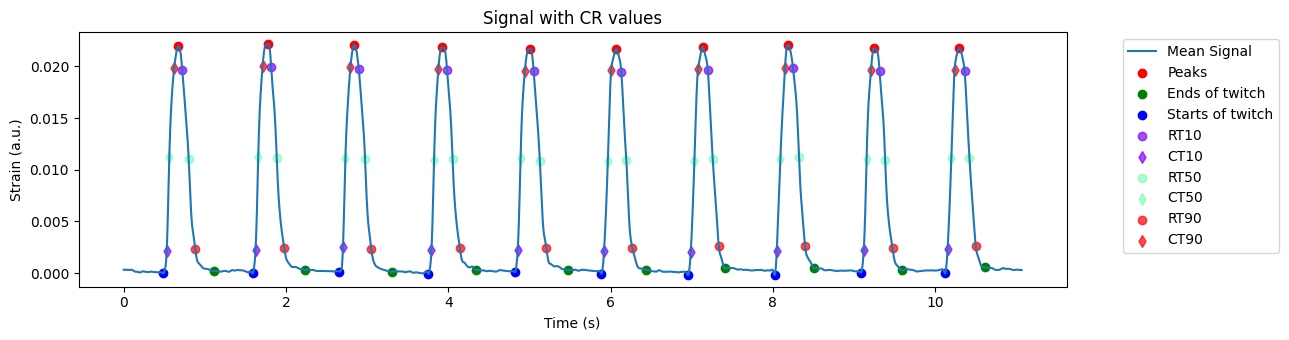

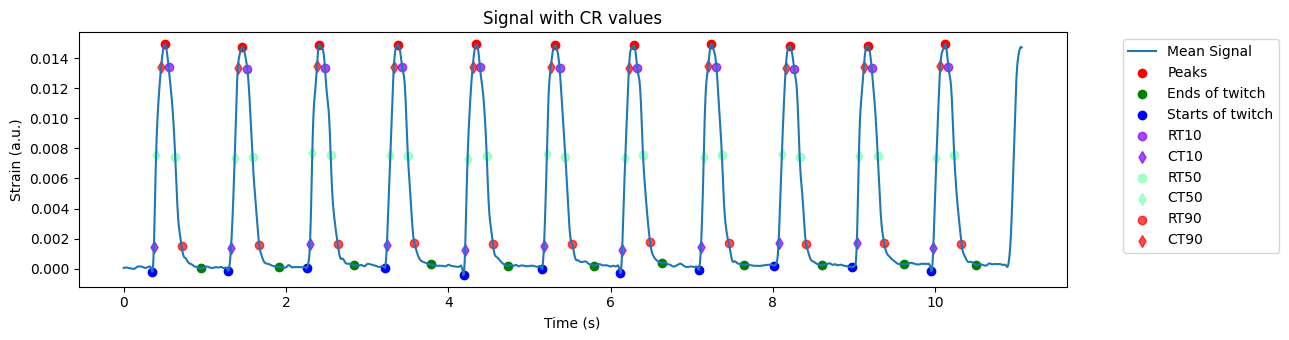

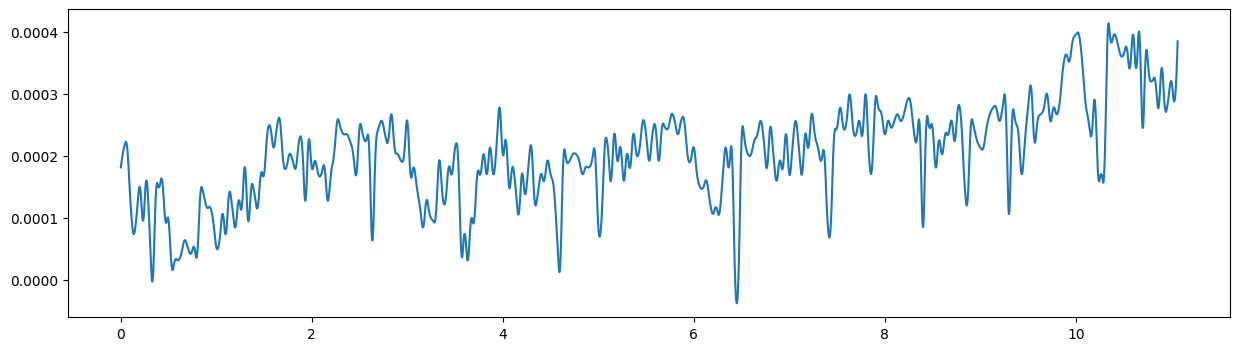

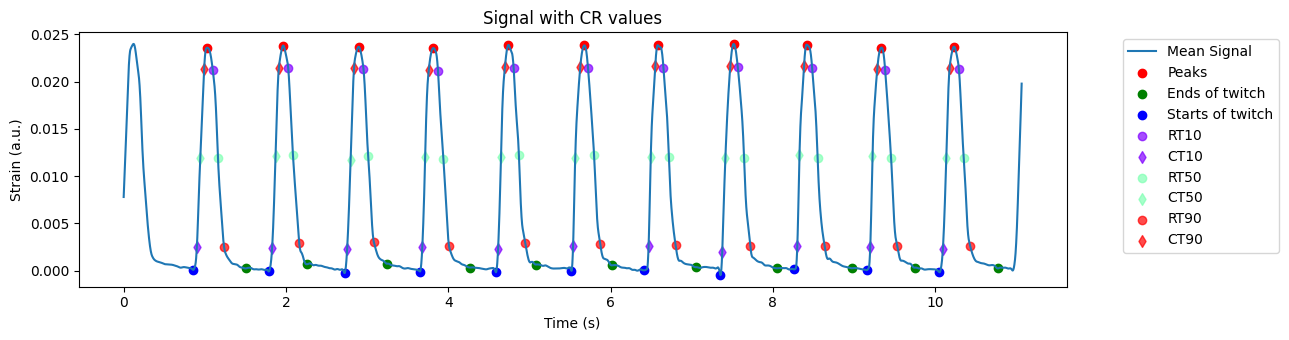

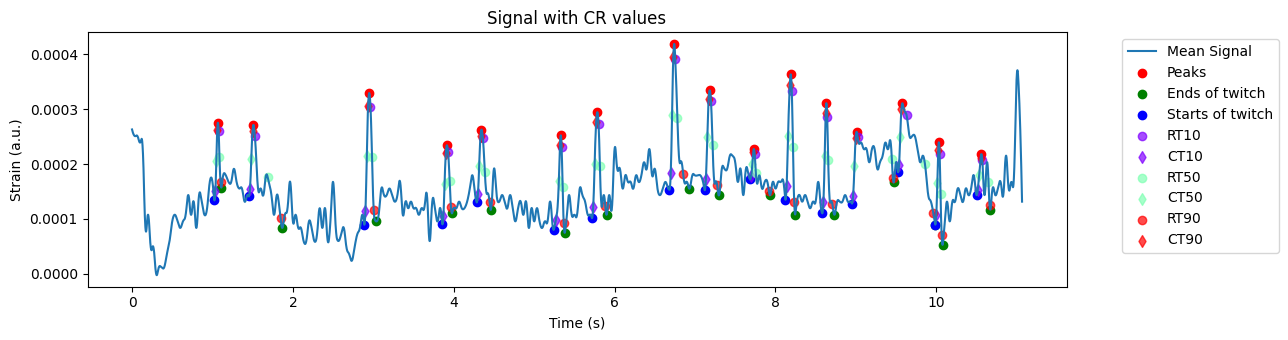

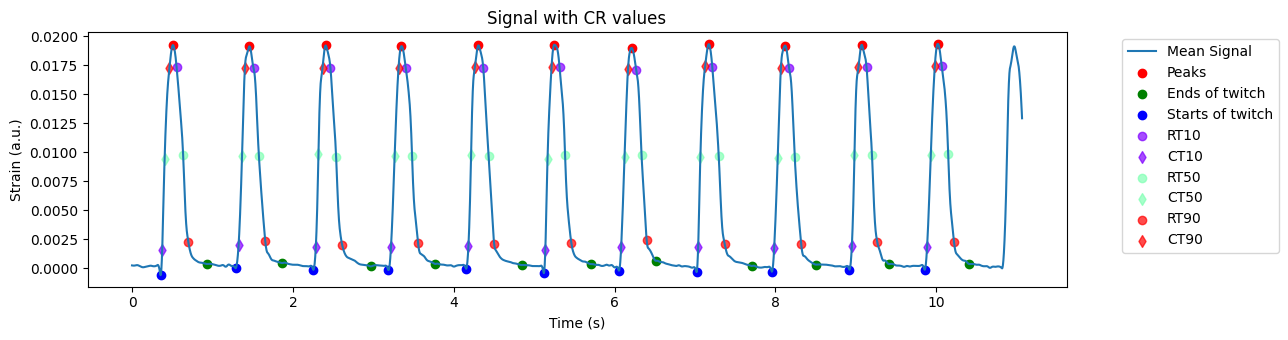

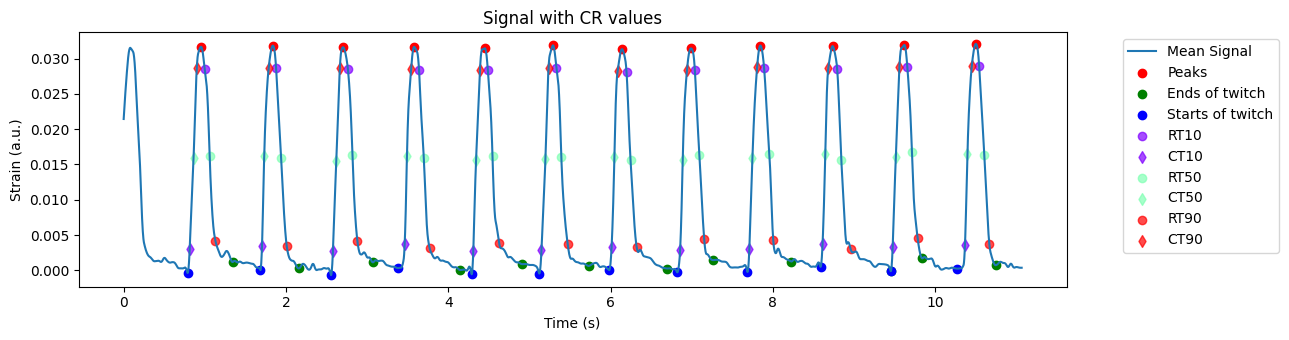

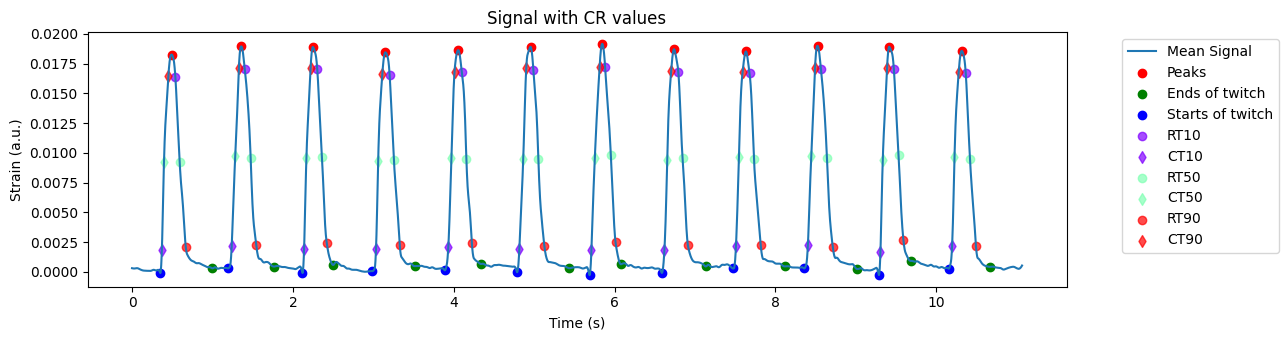

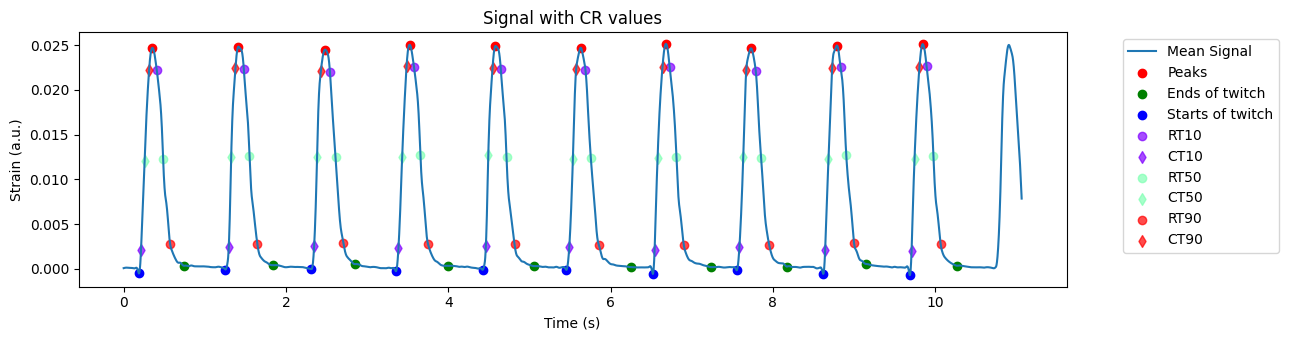

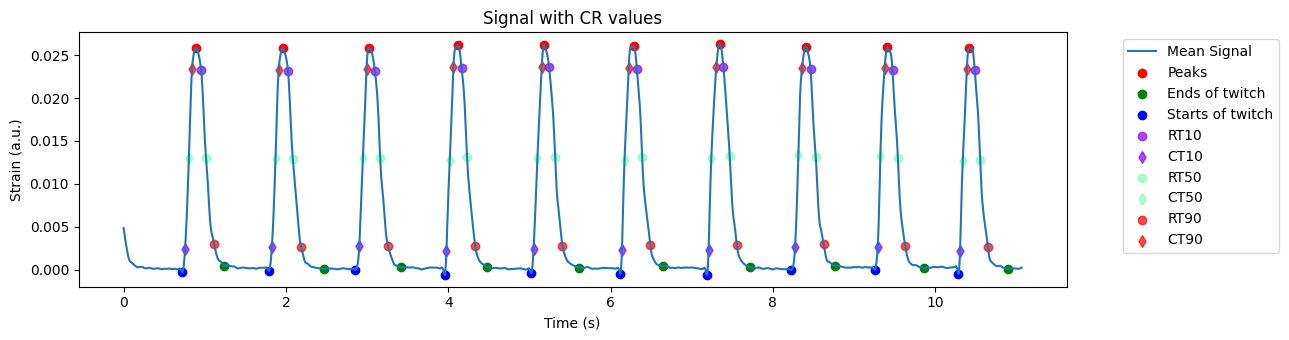

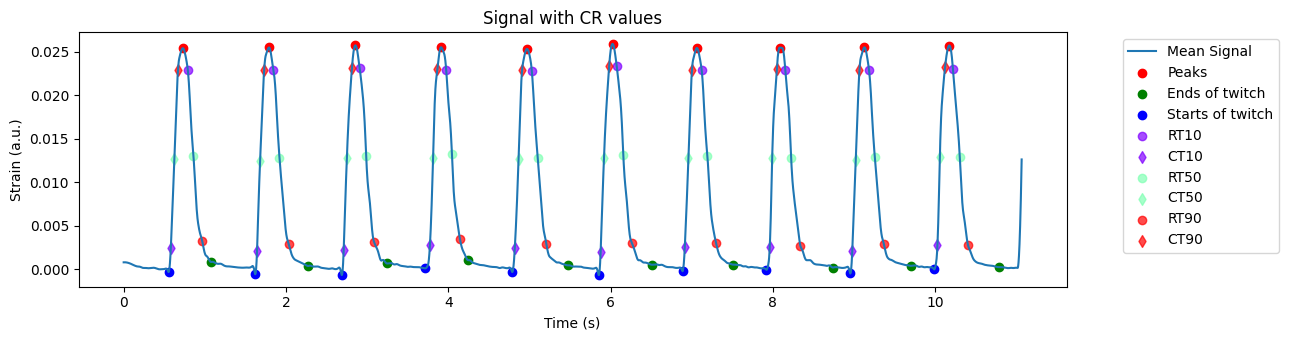

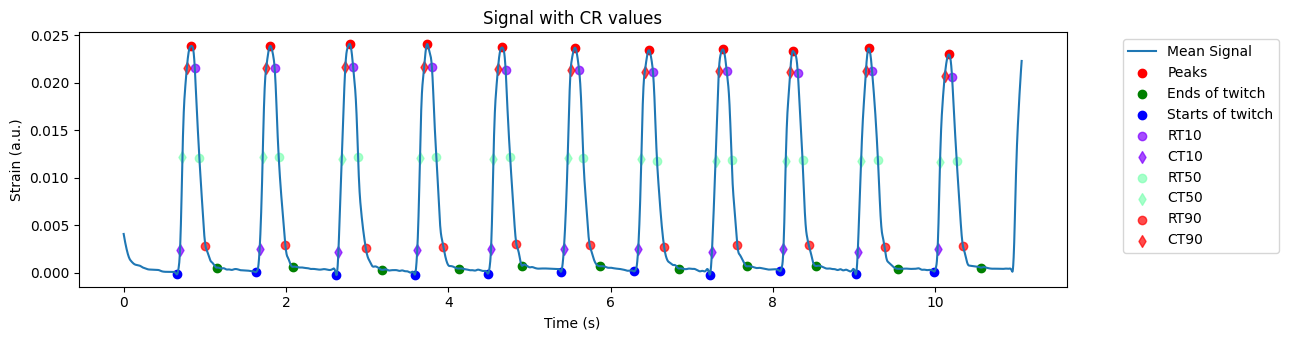

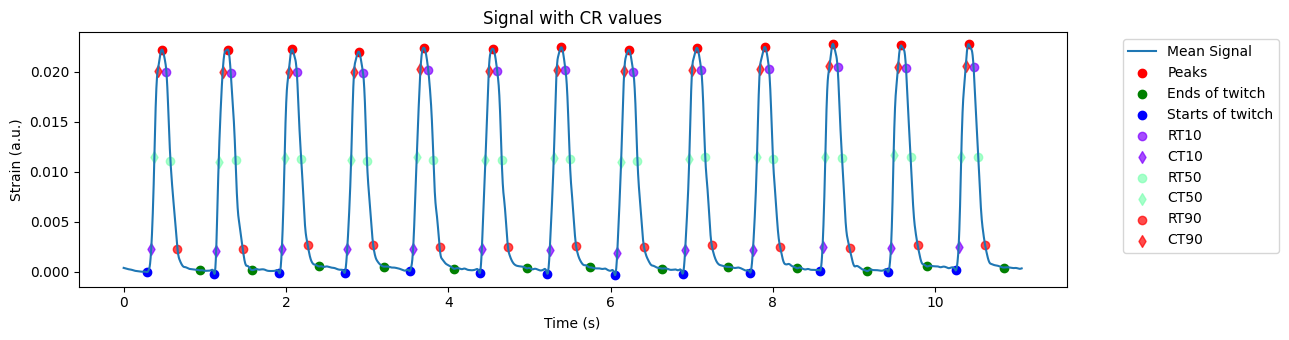

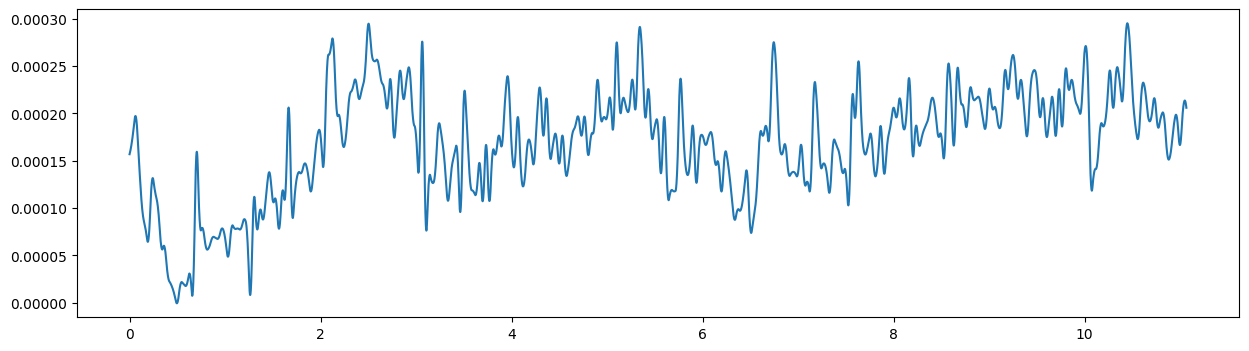

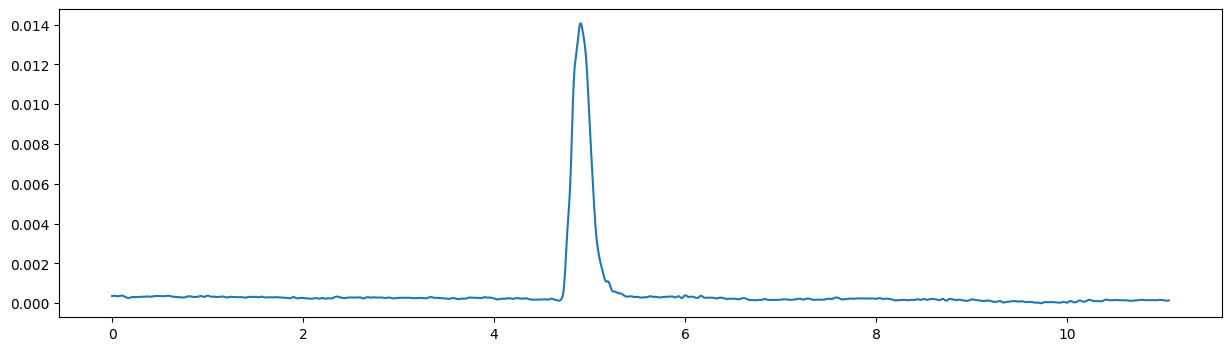

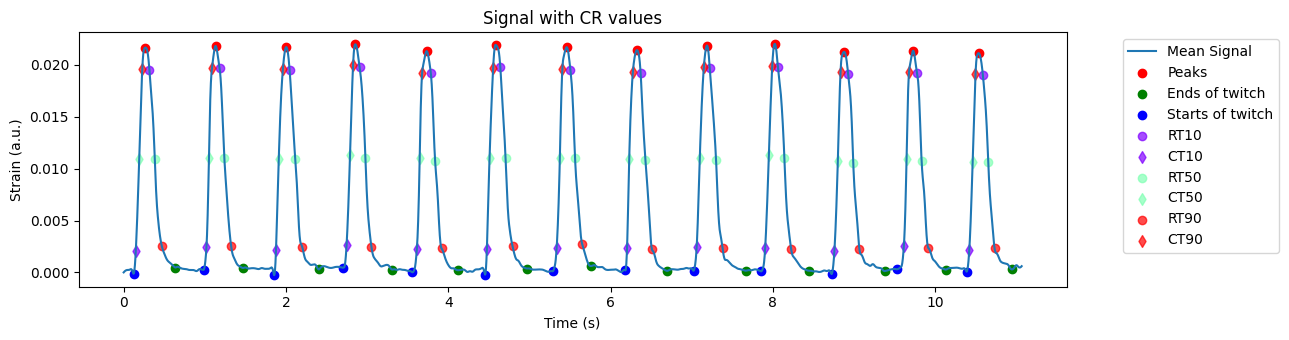

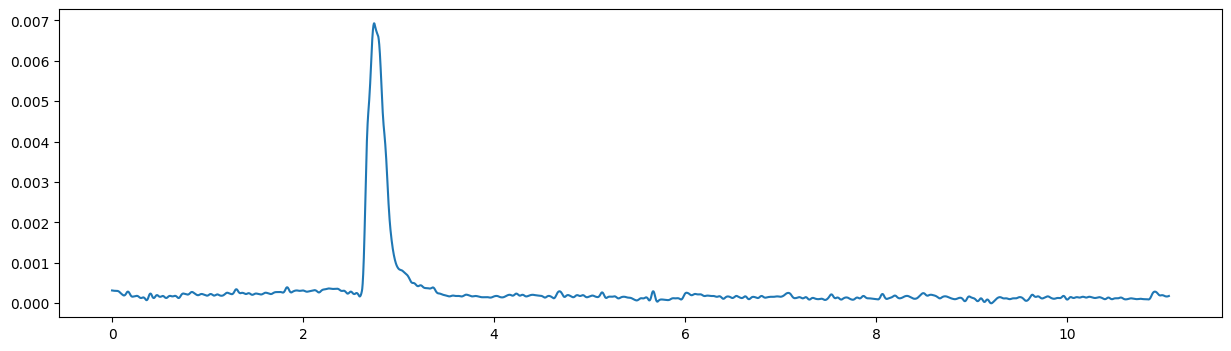

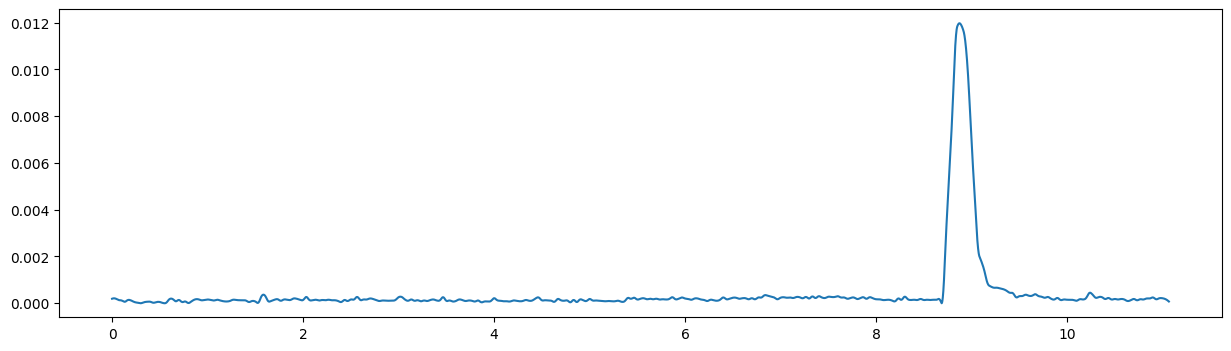

In [10]:
'''
Loop through all folders/conditions in folder
'''

for i, condition in enumerate(conditions):
    print("Analyzing condition: "+ condition)
    path = f'{folder}/{condition}'
    files = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            file = os.path.join(path, file)
            files.append(file) # list of all files in folder condition

    # Create Results folder if it doesn't exist
    if not os.path.exists(f'{folder}/Results'):
        os.makedirs(f'{folder}/Results')
    if not os.path.exists(f'{folder}/Results/{condition}'):
        os.makedirs(f'{folder}/Results/{condition}')

    # Initializing dataframe to store results 
    CR_percents = [10,50, 90]
    columns = ['Name', 'Total video time','SNR','Initial Youngs Modulus', 'Days in culture','Period (s)', 'Beating Frequency (Hz)', 'Interpeak irregularity (s)', 'N_twitch','Contraction strain (A.U.)','Maximum contraction speed (A.U./s)','Maximum relaxation speed (A.U./s)', 'Contraction stress (mN/mm2)','Contraction time (s)', 'Relaxation time (s)', 'Contraction-relaxation time (s)']
    for p in CR_percents:
        columns.append(f'Contraction time {p} (s)')
        columns.append(f'Relaxation time {p} (s)')
    aggregated_results = pd.DataFrame(index=range(len(files)), columns=columns)


    '''
    Loop through all files in folder/condition and analyses them
    '''
    for f in range(len(files)):
        name = os.path.basename(files[f]).split('.')[0]  # whole file name without extension
        name = name.split('_', 1)[1] # TODO: remove this after modification in java code, right now it removes "rawresults_" in front of name
        name_condition = name.rsplit('_', 1)[0] # name and condition without well and ring number
        print('Processing file: ', name)


        ''' 1. Load and plot raw data '''
        raw_data = pd.read_csv(files[f])

        # radius_column = next(col for col in raw_data.columns if col.startswith('Internal radius')) # find column with 'Mean' in its name
        # radius_signal=raw_data[[radius_column]].values.flatten()

        # time_column = next(col for col in raw_data.columns if col.startswith('Time')) # convert time index to seconds
        # time_signal=raw_data[[time_column]].values.flatten()



        radius_column = next(col for col in raw_data.columns if col.startswith('intern_radius')) # find column with 'Mean' in its name
        radius_signal=raw_data[[radius_column]].values.flatten()

        time_column = next(col for col in raw_data.columns if col.startswith('frame_time')) # convert time index to seconds
        time_signal=raw_data[[time_column]].values.flatten()

        #calculate strain and stress signals
        max_radius=np.max(radius_signal)
        strain_signal = ((max_radius - radius_signal) / max_radius)
        stress_signal = strain_signal * Youngs_Modulus

        ''' 2. Basic video parameters '''
        deltaT=np.mean(np.diff(time_signal))
        frame_rate=1/(deltaT)

        video_time=time_signal[-1]
        

        # plt.figure(figsize=(15, 4)) # plot raw data
        # plt.plot(time_signal, strain_signal)
        # plt.xlabel('Time (s)')
        # plt.ylabel('Strain')
        # plt.title('Raw plot '+name) 
        # plt.show()

        

        '''3. Data interpolation '''
        n_points = 10000  # points in interpolated signal (a bit arbitrary maybe)
        interp_func = interp1d(time_signal, strain_signal, kind='quadratic')
        interp_func2 = interp1d(time_signal, radius_signal, kind='quadratic')
        time_interp = np.linspace(np.min(time_signal), np.max(time_signal), n_points)   # create a new time array with more points
        mean_interp = interp_func(time_interp) # interpolation
        signal_interp = pd.DataFrame() # store all interpolated signals in new dataframe (they have different lengths)
        signal_interp['Time (s)'] = time_interp
        signal_interp['Radius'] = interp_func2(time_interp)
        signal_interp['Strain'] = mean_interp

        Total_time=time_interp[-1]
                

        strain_interp_signal=signal_interp[['Strain']].values.flatten()

        frame_rate_interp=1/(video_time/len(strain_interp_signal))

        '''4. Preliminary frequency fft '''

        # --- Butterworth filter ---
        Fs = frame_rate_interp  # Sampling frequency
        fc = 5 # Cut-off frequency (Hz)

        # Design 2nd order Butterworth low-pass filter
        b, a = butter(2, fc / (Fs / 2), btype='low')  # Fs/2 is the Nyquist frequency

        Filtered_strain_signal=filtfilt(b,a,strain_interp_signal)

        # --- Frequency analysis using FFT ---
        signal = Filtered_strain_signal
        L = len(signal)
        Y = fft(signal)
        fftfreq = (frame_rate_interp) * np.arange(0, L // 2 + 1) / L

        # FFT amplitude
        P2 = np.abs(Y / L)
        P1 = P2[:L // 2 + 1]
        P1[1:-1] = 2 * P1[1:-1]  # Multiply by 2 (except first and last) for symmetry

        # Find FFT peaks
        fftpeaks_index,_= find_peaks(P1)

        # plt.figure(figsize=(15, 4)) # plot raw data
        # plt.plot(P1)
        # plt.plot(fftpeaks_index,P1[fftpeaks_index],'*')
        # plt.xlabel('Index')
        # plt.ylabel('fft')
        # plt.show()

        # Get peak with max amplitude
        fftmax_index = np.argmax(P1[fftpeaks_index])
        freqfromfft = fftfreq[fftpeaks_index[fftmax_index]]
        print(freqfromfft)


        ''' 5. Peak detection '''

        #Signal to noise ratio
        SNR=signaltonoise(strain_interp_signal)

        


        # if SNR>2.5:
        #     Noise="Yes"
        #     print('Signal too noisy, SNR= %f ' %SNR)
        # else:
        #     Noise="No"

        # match Noise:
            
            # case "Yes":

            #     period=None
            #     frequency=None
            #     interpeak_std = None
            #     n_twitch=None
            #     mean_strain=None
            #     Max_Contraction_speed=None
            #     Max_Relaxation_speed=None
            #     stress=None
            #     Contraction_time=None
            #     Relaxation_time=None
            #     contraction_relaxation=None

            #     results_dict ={
            #         'Name':name,
            #         'Total video time': Total_time,
            #         'SNR':SNR,
            #         'Initial Youngs Modulus': Initial_Youngs_Modulus,
            #         'Days in culture': Days_Culture,
            #         'Period (s)': period,
            #         'Beating Frequency (Hz)': frequency,
            #         'Interpeak irregularity (s)': interpeak_std,
            #         'N_twitch': n_twitch,
            #         'Contraction strain (A.U.)':mean_strain,
            #         'Maximum contraction speed (A.U./s)':Max_Contraction_speed,
            #         'Maximum relaxation speed (A.U./s)': Max_Relaxation_speed,
            #         'Contraction stress (mN/mm2)': stress,
            #         'Contraction time (s)': Contraction_time,
            #         'Relaxation time (s)': Relaxation_time,
            #         'Contraction-relaxation time (s)':contraction_relaxation}
                
            #     for p in CR_percents:  # add APD metrics using apd_percents list
            #         results_dict[f'CT{p} (s)'] = None
            #         results_dict[f'RT{p} (s)'] = None
                
            #     plt.figure(figsize=(15, 4))
            #     plt.plot(signal_interp['Time (s)'], strain_interp_signal, label='Strain Signal')
            #     plt.savefig(f'{folder}/Results/{condition}/{name}_signal.png', facecolor = 'w', bbox_inches="tight", pad_inches=0.3)
            #     plt.show()
                
            #     aggregated_results.iloc[f] = pd.Series(results_dict)
            #     signal_to_save = signal_interp[['Time (s)', 'Radius','Strain']]
            #     signal_to_save.columns = ['Time (s)', 'Radius (pixels)','Strain (A.U.)'] 
            #     signal_to_save.insert(0, 'Name', name)
            #     signal_to_save.to_csv(f'{folder}/Results/{condition}/{name}_signal.csv', index=False) # save the signal as CSVs


            
            # case 'No':
                # Quantacell Peak detection

        dStrain=np.diff(strain_interp_signal)


        # MIN_SLOPE=np.mean(dStrain[dStrain>0]*0.1)
        # MIN_SLOPE=0
        # MIN_DURATION=0
        MIN_DISTANCE=1/freqfromfft/5*frame_rate_interp


        


        # results = analyze_signal_peaks(strain_interp_signal,
        #                                     prct_1=PRCT_1, prct_2=PRCT_2,
        #                                     sample_rate=frame_rate_interp,
        #                                     min_duration=MIN_DURATION,
        #                                     min_distance=MIN_DISTANCE,
        #                                     min_flow=MIN_EXPANSION_FLOW,
        #                                     min_slope=MIN_SLOPE,
        #                                     window_slope_size=WINDOW_SLOPE_SIZE,
        #                                     verbose=True)

        # all_peaks=np.asarray(results["high_peak_indices"])

        MinHeight=PRCT_2/100*np.max(strain_interp_signal)
        all_peaks,_=find_peaks(strain_interp_signal,height=MinHeight,distance=MIN_DISTANCE)

        # plot_signal_with_filtered_peaks(strain_signal, frame_rate, results)

        
        MaxStrain=np.max(strain_interp_signal)
        MinStrain=np.min(strain_interp_signal)

        if len(all_peaks)==0:
            continue

        max_trough = (MaxStrain-MinStrain)*0.5 + MinStrain
        all_troughs, _ = find_peaks(-strain_interp_signal, height = (-max_trough, None))
        # all_troughs, _ = find_peaks(-strain_interp_signal)  

        # plt.figure(figsize=(15, 4))
        # plt.plot(time_interp, strain_interp_signal, label='Strain Signal')
        # plt.plot(time_interp[all_peaks], strain_interp_signal[all_peaks],'*', label='Peaks')
        # plt.plot(time_interp[pretroughs], strain_interp_signal[pretroughs],'*',color='red', label='pretroughs')
        # plt.plot(time_interp[all_troughs], strain_interp_signal[all_troughs],'*',color='green', label='troughs')



        # print('test=%f'%all_peaks[-1])
        peaks, pretroughs, troughs, passs, message = sort_peaks_troughs(strain_interp_signal,all_peaks, all_troughs,50)
        if passs:
            print(message)
            period=None
            frequency=None
            interpeak_std = None
            if len(all_peaks)>0:
                n_twitch=len(all_peaks)
            else:
                n_twitch=None                
            mean_strain=None                    
            Max_Contraction_speed=None
            Max_Relaxation_speed=None
            stress=None
            Contraction_time=None
            Relaxation_time=None
            contraction_relaxation=None

            results_dict ={
                'Name':name,
                'Total video time': Total_time,
                'SNR':SNR,
                'Initial Youngs Modulus': Initial_Youngs_Modulus,
                'Days in culture': Days_Culture,
                'Period (s)': period,
                'Beating Frequency (Hz)': frequency,
                'Interpeak irregularity (s)': interpeak_std,
                'N_twitch': n_twitch,
                'Contraction strain (A.U.)':mean_strain,
                'Maximum contraction speed (A.U./s)':Max_Contraction_speed,
                'Maximum relaxation speed (A.U./s)': Max_Relaxation_speed,
                'Contraction stress (mN/mm2)': stress,
                'Contraction time (s)': Contraction_time,
                'Relaxation time (s)': Relaxation_time,
                'Contraction-relaxation time (s)':contraction_relaxation}
            
            for p in CR_percents:  # add APD metrics using apd_percents list
                results_dict[f'CT{p} (s)'] = None
                results_dict[f'RT{p} (s)'] = None
            
            plt.figure(figsize=(15, 4))
            plt.plot(signal_interp['Time (s)'], strain_interp_signal, label='Strain Signal')
            plt.savefig(f'{folder}/Results/{condition}/{name}_signal.png', facecolor = 'w', bbox_inches="tight", pad_inches=0.3)
            # plt.show()
        
            aggregated_results.iloc[f] = pd.Series(results_dict)
            signal_to_save = signal_interp[['Time (s)', 'Radius','Strain']]
            signal_to_save.columns = ['Time (s)', 'Radius (pixels)','Strain (A.U.)'] 
            signal_to_save.insert(0, 'Name', name)
            signal_to_save.to_csv(f'{folder}/Results/{condition}/{name}_signal.csv', index=False) # save the signal as CSVs

            continue

        # plt.figure(figsize=(15, 4))
        # plt.plot(time_interp, strain_interp_signal, label='Strain Signal')
        # plt.plot(time_interp[peaks], strain_interp_signal[peaks],'*', label='Peaks')
        # plt.plot(time_interp[pretroughs], strain_interp_signal[pretroughs],'*',color='red', label='pretroughs')
        # plt.plot(time_interp[troughs], strain_interp_signal[troughs],'*',color='green', label='troughs')

        # plt.figure(figsize=(15, 4))
        # plt.plot(time_interp[1:], dStrain, label='Strain Signal')
        # plt.plot(time_interp[peaks], dStrain[peaks],'*', label='Peaks')
        # plt.plot(time_interp[pretroughs], dStrain[pretroughs],'*',color='red', label='pretroughs')
        # plt.plot(time_interp[troughs], dStrain[troughs],'*',color='green', label='troughs')




        


        ''' 6. Derivative of the signal '''
        dt=np.mean(np.diff(time_interp))
        dStrain_dt=dStrain/dt

        MaxSpeedHeight=np.max(dStrain_dt)*0.4
        MinSpeedHeight=np.max(-dStrain_dt)*0.3
        if len(peaks)>1:
            MinDistance=np.mean(np.diff(time_interp[peaks]))*frame_rate_interp*0.3 #at least 1/3 of the period (indices)
        else:
            MinDistance=0

        speed_max_peaks,_=find_peaks(dStrain_dt,height=MaxSpeedHeight,distance=MinDistance)
        speed_min_peaks,_=find_peaks(-dStrain_dt,height=MinSpeedHeight,distance=MinDistance)

        # plt.figure(figsize=(15, 4)) # plot raw data
        # plt.plot(time_interp[1:],dStrain_dt)
        # plt.plot(time_interp[speed_max_peaks], dStrain_dt[speed_max_peaks],'*',color='red', label='Max')
        # plt.plot(time_interp[speed_min_peaks], dStrain_dt[speed_min_peaks],'*', color='green',label='Min')
        # plt.plot(time_interp[pretroughs], dStrain_dt[pretroughs],'*',color='red', label='pretroughs')
        # plt.plot(time_interp[troughs], dStrain_dt[troughs],'*', color='green',label='troughs')
        # plt.xlabel('Time (s)')
        # plt.ylabel('Velocity')
        # plt.show()

        ''' 7. Compute main metrics here '''
        interpeak_distance = np.diff(time_interp[peaks])
        period = np.mean(interpeak_distance) 
        frequency=1/period
        interpeak_std = np.std(interpeak_distance) # will be None if only 2 peaks
        n_twitch=len(peaks)

        strain_maxima = np.array(strain_interp_signal[peaks]) - np.array(strain_interp_signal[pretroughs])
        mean_strain = np.mean(strain_maxima)
        std_strain = np.std(strain_maxima)
        stress=mean_strain * Youngs_Modulus


        Max_Contraction_speed = np.mean(dStrain_dt[speed_max_peaks])
        Max_Relaxation_speed = abs(np.mean(dStrain_dt[speed_min_peaks]))


        Contraction_time = np.mean(time_interp[peaks] - time_interp[pretroughs])
        Relaxation_time=np.mean(time_interp[troughs] - time_interp[peaks])
        contraction_relaxation = np.mean(time_interp[troughs]- time_interp[pretroughs]) # time between pretrough and trough = contraction-relaxation

        ''' 8. Compute contraction and relaxation times '''

        relax, relax_x, relax_y, contrac, contrac_x, contrac_y = get_ContractionPoints(i, CR_percents, peaks,strain_interp_signal,time_interp, pretroughs, troughs) # compute APD values for each action potential

            # Plot the results on whole signal
        plt.figure(figsize=(13, 3.5))
        plt.plot(time_interp, strain_interp_signal, label='Mean Signal')
        plt.scatter(time_interp[peaks], strain_interp_signal[peaks], color='red', label='Peaks')
        plt.scatter(time_interp[troughs], strain_interp_signal[troughs], color='green', label='Ends of twitch')
        plt.scatter(time_interp[pretroughs], strain_interp_signal[pretroughs], color='blue', label='Starts of twitch')
        colors = plt.cm.rainbow(np.linspace(0, 1, len(CR_percents))) # plot APD points with different colors
        for (p, color) in zip(CR_percents, colors):
            plt.scatter(relax_x[f'relax{p}_x'], relax_y[f'relax{p}_y'], 
                        color=color, label=f'RT{p}', marker='o', alpha=0.7)
            plt.scatter(contrac_x[f'contrac{p}_x'], contrac_y[f'contrac{p}_y'], 
                        color=color,label=f'CT{p}', marker='d', alpha=0.7)
        plt.title("Signal with CR values")
        plt.xlabel('Time (s)')
        plt.ylabel('Strain (a.u.)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{folder}/Results/{condition}/{name}_plot.png', facecolor = 'w', bbox_inches="tight", pad_inches=0.3)
        # plt.show()

        

        
        ''' 8. Save signal and metrics '''
    
        # add param means to results_dict
        results_dict ={
            'Name':name,
            'Total video time': Total_time,
            'SNR':SNR,
            'Initial Youngs Modulus': Initial_Youngs_Modulus,
            'Days in culture': Days_Culture,
            'Period (s)': period,
            'Beating Frequency (Hz)': frequency,
            'Interpeak irregularity (s)': interpeak_std,
            'N_twitch': n_twitch,
            'Contraction strain (A.U.)':mean_strain,
            'Maximum contraction speed (A.U./s)':Max_Contraction_speed,
            'Maximum relaxation speed (A.U./s)': Max_Relaxation_speed,
            'Contraction stress (mN/mm2)': stress,
            'Contraction time (s)': Contraction_time,
            'Relaxation time (s)': Relaxation_time,
            'Contraction-relaxation time (s)':contraction_relaxation}


        for p in CR_percents:  # add APD metrics using apd_percents list
            results_dict[f'CT{p} (s)'] = np.mean(contrac[f'contrac{p}'])
            results_dict[f'RT{p} (s)'] = np.mean(relax[f'relax{p}'])

        aggregated_results.iloc[f] = pd.Series(results_dict)  # add results dict as a line of aggregated_results dataframe without using append

        StrainPoints = pd.DataFrame({**contrac, **relax, **relax_x, **relax_y, **contrac_x, **contrac_y})
        StrainPoints.insert(0, 'Name', name)
        StrainPoints.insert(1, 'Pretroughs', pretroughs)
        StrainPoints.insert(2, 'Pretroughs_x', np.array(time_interp[pretroughs]))
        StrainPoints.insert(3, 'Pretroughs_y', np.array(strain_interp_signal[pretroughs]))
        StrainPoints.insert(4, 'Peaks', peaks)
        StrainPoints.insert(5, 'Peaks_x', np.array(time_interp[peaks]))
        StrainPoints.insert(6, 'Peaks_y', np.array(strain_interp_signal[peaks]))
        StrainPoints.insert(7, 'Troughs', troughs)
        StrainPoints.insert(8, 'Troughs_x', np.array(time_interp[troughs]))
        StrainPoints.insert(9, 'Troughs_y', np.array(strain_interp_signal[troughs]))
        StrainPoints.to_csv(f'{folder}/Results/{condition}/{name}_ContractionPoints.csv', index=False) # save CT and CR points as CSVs

        signal_to_save = signal_interp[['Time (s)', 'Radius','Strain']]
        signal_to_save.columns = ['Time (s)', 'Radius (pixels)','Strain (A.U.)'] 
        signal_to_save.insert(0, 'Name', name)
        signal_to_save.to_csv(f'{folder}/Results/{condition}/{name}_signal.csv', index=False) # save the signal as CSVs

    # Save params as one csv for whole condition
    aggregated_results.to_csv(f'{folder}/Results/{condition}/{name_condition}_param_means.csv', index=False)

    print('All signals from condition '+condition+' processed!\n\n\n')

print('All conditions processed!')